## Kaggle Dogbreeds

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

from fastai.plots import *

In [3]:
PATH = "data/dogbreeds/"
TRAIN = "train/"; VALID = "valid/"; TEST = "test/"; SUBM = "subm/"; RSLT = "results/"

In [4]:
sz = 224
bs = 12
# arch = resnext101_64
arch = resnext50
# arch = resnet34
# arch = resnet50

Explanation of the following code: `get_cv_idxs(..)`:
```
def get_cv_idxs(n, cv_idx=4, val_pct=0.2, seed=42):
1    np.random.seed(seed)
2    n_val = int(val_pct*n)
3    idx_start = cv_idx*n_val
4    idxs = np.random.permutation(n)
5    return idxs[idx_start:idx_start+n_val]
```
function takes in `n` number, `cv_idx` cross-validation index (default `4`), `val_pct` validation percent (default 20%), and a seed (default meaning of life).

* Line 1 seeds the NumPy random number generator (ensures reproducible results).
* Line 2 sets `n_val` number of valids to be `floor(`validation percent `x` total number`)`.
* Line 3 sets `idx_start` starting index to be the number of valids `n_val` times the cross-validation index.
* Line 4 sets the indices `idxs` to be a random permutation of all integers `[0:n)`
* Line 5 returns a `n_val` wide slice of the `idxs` array starting at `idx_start`

I don't know yet what the significance of `cv_idx` is.

In [5]:
# Counts lines in labels.csv. File contains all labels --> can use as a filecount
# Pass filecount n into val_idxs(n) 
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [6]:
tfms = tfms_from_model(arch, bs, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=label_csv,
                                    bs=bs, tfms=tfms, val_idxs=val_idxs, suffix='.jpg')

In [7]:
learn = ConvLearner.pretrained(arch, data=data)

In [8]:
list(zip(data.classes))[:10]

[('affenpinscher',),
 ('afghan_hound',),
 ('african_hunting_dog',),
 ('airedale',),
 ('american_staffordshire_terrier',),
 ('appenzeller',),
 ('australian_terrier',),
 ('basenji',),
 ('basset',),
 ('beagle',)]

A Jupyter Widget

  1%|          | 4/682 [00:01<03:51,  2.92it/s, loss=5.2] 

/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 80%|███████▉  | 544/682 [00:21<00:05, 24.83it/s, loss=21.6]

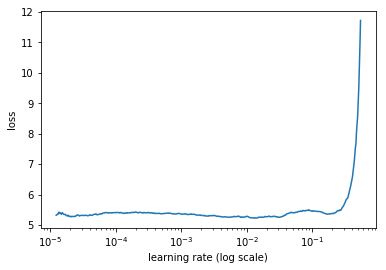

 80%|███████▉  | 544/682 [00:40<00:10, 13.58it/s, loss=21.6]

In [9]:
lrf = learn.lr_find()
learn.sched.plot()

In [10]:
lr = 2e-2

In [11]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

                                                            
                                                            
                                                            
                                                            
                                                            
                                                            
                                                            
                                                            

                                                            
                                                            
                                                            
                                                            
                                                            


                                                            

  1%|          | 4/682 [00:00<01:20,  8.41it/s, loss=5.33]

/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



 12%|█▏        | 82/682 [00:03<00:26, 23.02it/s, loss=5.44]

 13%|█▎        | 88/682 [00:03<00:25, 23.16it/s, loss=5.46] [A

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed

[ 0.       4.77925  4.62485  0.03411]                       
[ 1.       4.57017  4.53765  0.03996]                       
[ 2.       4.46189  4.5175   0.04435]                       
[ 3.       4.51572  4.54183  0.04142]                       
[ 4.       4.40379  4.47268  0.04776]                       
[ 5.       4.31973  4.45794  0.04435]                       
[ 6.       4.23797  4.46152  0.04532]                       



In [12]:
lrs = np.array([lr/9,lr/3,lr])

In [13]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  0%|          | 1/682 [00:00<04:58,  2.28it/s, loss=4.72]

/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       4.72217  4.69463  0.01852]                       
[ 1.       4.68598  4.62722  0.01511]                       
[ 2.       4.60267  4.60278  0.02729]                       
[ 3.       4.68185  4.62183  0.02583]                       
[ 4.       4.60635  4.55476  0.02388]                       
[ 5.       4.56302  4.52383  0.02875]                       
[ 6.       4.5056   4.52512  0.03216]                       



In [14]:
learn.save(f'{sz}_dogbreeds_RN50_00')